# Variational AutoEncoder
## creating the model

In [60]:
import torch
from torch import nn

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        
        self.mu = mu
        self.sigma = sigma
        
        return x_reconstructed, mu, sigma


if __name__ == "__main__":
    x = torch.randn(4, 28*28)
    vae = VariationalAutoEncoder(input_dim=784)
    x_reconstructed, mu, sigma = vae(x)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


# train

In [62]:
import torch
import torchvision.datasets as datasets  # Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 2e-4  # Karpathy constant

In [63]:
# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [2]:
# Start Training
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        # Forward pass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(x)

        # Compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Backprop
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
torch.save(model.state_dict(), "VAE_model.pt")

1875it [00:26, 71.08it/s, loss=5.65e+3]
1875it [00:26, 70.60it/s, loss=5.08e+3]
1875it [00:26, 70.79it/s, loss=4.88e+3]
1875it [00:26, 71.30it/s, loss=4.56e+3]
1875it [00:26, 71.02it/s, loss=4.36e+3]
1875it [00:26, 70.80it/s, loss=4.22e+3]
1875it [00:26, 70.53it/s, loss=4.52e+3]
1875it [00:27, 68.53it/s, loss=4.25e+3]
1875it [00:26, 70.13it/s, loss=4.28e+3]
1875it [00:26, 70.46it/s, loss=4.07e+3]


## loading the pretrained model

In [64]:
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
model.load_state_dict(torch.load("VAE_model.pt"))

<All keys matched successfully>

# test

In [65]:
images = []
idx = 0
for x, y in dataset:
    if y == idx:
        images.append(x)
        idx += 1
        if idx == 10:
            break

which number you want to generate ? 2


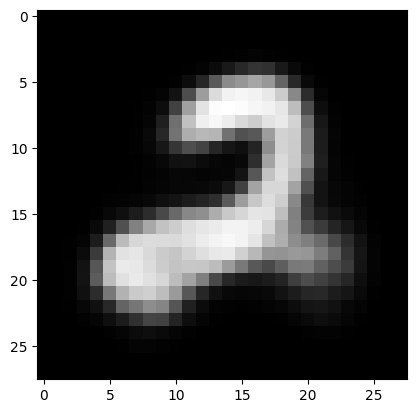

In [66]:
import matplotlib.pyplot as plt

num_input = int(input('which number you want to generate ? '))
model = model.to("cpu")
with torch.no_grad():
    mu, sigma = model.encode(images[num_input].view(1, 784))
epsilon = torch.randn_like(sigma)
z = mu + sigma * epsilon
out = model.decode(z)
out = out.view(-1, 1, 28, 28)
plt.imshow(out.cpu().detach()[0][0] , cmap = "gray")
plt.show()

# Conditional Variational Autoencoder

## creating the model

In [68]:
import torch
from torch import nn
import torch.nn.functional as F

class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20, n_classes=10):
        super().__init__()
        
        # encoder
        self.img_2hid = nn.Linear(input_dim + n_classes, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim + n_classes, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x , condition):
        x_with_condition = torch.cat((x, condition), 1) 
        mu, sigma = self.encode(x_with_condition)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        z_with_condition = torch.cat((z_new, condition), 1) 
        x_reconstructed = self.decode(z_with_condition)
        
        self.mu = mu
        self.sigma = sigma
        
        return x_reconstructed, mu, sigma


if __name__ == "__main__":
    x = torch.randn(4, 28*28 + 10)
    cvae = ConditionalVariationalAutoEncoder(input_dim=28*28 + 10)
    condition = F.one_hot(torch.arange(0, 4), num_classes=10)
    x_reconstructed, mu, sigma = cvae(x,condition)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)

torch.Size([4, 794])
torch.Size([4, 20])
torch.Size([4, 20])


## train

In [69]:
import torch
import torchvision.datasets as datasets  # Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 28*28
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 10
LR_RATE = 2e-4  # Karpathy constant

In [70]:
# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ConditionalVariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM, NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [29]:
# Start Training
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, y) in loop:
        # Forward pass
        x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
        condition = F.one_hot(y, num_classes=10).to(DEVICE)
        x_reconstructed, mu, sigma = model(x , condition)

        # Compute loss
        reconstruction_loss = loss_fn(x_reconstructed, x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Backprop
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
torch.save(model.state_dict(), "CVAE_model.pt")

1875it [00:39, 47.33it/s, loss=5.28e+3]
1875it [00:41, 45.42it/s, loss=5.1e+3] 
1875it [00:40, 45.81it/s, loss=4.72e+3]
1875it [00:41, 45.69it/s, loss=4.15e+3]
1875it [00:40, 46.68it/s, loss=4.27e+3]
1875it [00:38, 48.46it/s, loss=4.2e+3] 
1875it [00:40, 45.91it/s, loss=4.02e+3]
1875it [00:39, 47.78it/s, loss=3.85e+3]
1875it [00:38, 48.25it/s, loss=3.6e+3] 
1875it [00:39, 47.92it/s, loss=3.89e+3]


## loading the pretrained model

In [71]:
model = ConditionalVariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("CVAE_model.pt"))

<All keys matched successfully>

## test

In [72]:
images = []
idx = 0
for x, y in dataset:
    if y == idx:
        images.append(x)
        idx += 1
        if idx == 10:
            break

which number you want to generate ? 3


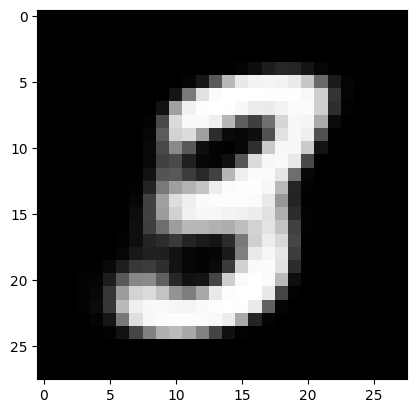

In [74]:
import matplotlib.pyplot as plt

num_input = int(input('which number you want to generate ? '))
model = model.to("cpu")
with torch.no_grad():
    condition = F.one_hot(torch.Tensor([num_input]).to(torch.int64), num_classes=10)
    x = images[num_input].view(1, INPUT_DIM)
    x_with_condition = torch.cat((x, condition), 1)
    mu, sigma = model.encode(x_with_condition)
epsilon = torch.randn_like(sigma)
z = mu + sigma * epsilon
z_with_condition = torch.cat((z, condition), 1)
out = model.decode(z_with_condition)
out = out.view(-1, 1, 28, 28)
plt.imshow(out.cpu().detach()[0][0] , cmap = "gray")
plt.show()